In [1]:
import numpy as np
import pandas as pd
import json
import os
import shutil
import subprocess as sp
import pyautogui as pg
import timeit
import time
from matplotlib import pyplot as plt
from model import Model, read_from_doc, write_to_doc
import h5py
import sys
from scipy.optimize import curve_fit
from ipywidgets import interact
import ipywidgets as widgets

In [2]:
def adjusted_weibull(x,a,b,c):
    return (b/a) * (x/b)**(b-1) * np.exp(-(x/a)**b) + c
def scaled_exp(x,a,b,c):
    return a*np.exp(-b*x) + c
def regan_weibull(x,a,b,c):
    return np.exp(-(x/a)**b) + c
# def weibull(x,d,e):
#     return (e/d) * (x/e)**(e-1) * np.exp(-(x/d)**e)
# def exp(x,d,e):
#     return d*np.exp(-e*x)

In [1]:
import torch
import numpy as np
import sbi
from sbi.inference import SNLE, prepare_for_sbi, simulate_for_sbi
from sbi.inference import likelihood_estimator_based_potential, MCMCPosterior
from sbi import utils as utils
from sbi import analysis as analysis

### Fecundity

Hows about fecundity

/var/folders/jd/fczwycqx1lxch_x4svbjh6680000gn/T/ipykernel_48085/595702587.py:8: RuntimeWarning: invalid value encountered in divide
  fecundity_err = fecundity * np.sqrt((prefire_density_se/prefire_density)**2 + (rec_density_se/rec_density)**2)


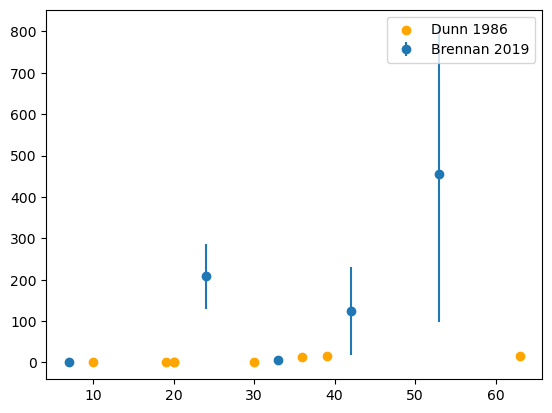

In [12]:
# Brennan 2019
stand_age = np.array([7,24,33,42,53])
prefire_density = np.array([2205,48,3430,233,400])
prefire_density_se = np.array([35,14,308,136,240])
rec_density = np.array([0,10000,18500,29000,182000])
rec_density_se = np.array([0,2345,9385,18443,92000])
fecundity = rec_density / prefire_density
fecundity_err = fecundity * np.sqrt((prefire_density_se/prefire_density)**2 + (rec_density_se/rec_density)**2)
plt.errorbar(stand_age, fecundity, yerr=fecundity_err, fmt='o', label='Brennan 2019')

# Dunn 1986
stand_age = [10,19,20,20,30,36,39,63]
fecundity = (np.array([0,0.1,2.9,26.5,15.7,1206.5,1387.3,1400]) / 100) + 1
plt.scatter(stand_age, fecundity, color='orange', label='Dunn 1986')

# Dunn 1984
# stand_age = [36,39]
# fecundity = (np.array([1206.5,1387.3]) / 100) + 1; fecundity
# plt.scatter(stand_age, fecundity, color='orange', label='Dunn 1984')

plt.legend()

### Mortality

#### Starting from old model

Here's what the survival rate looks like over ages x from the old model (Regan 2012)

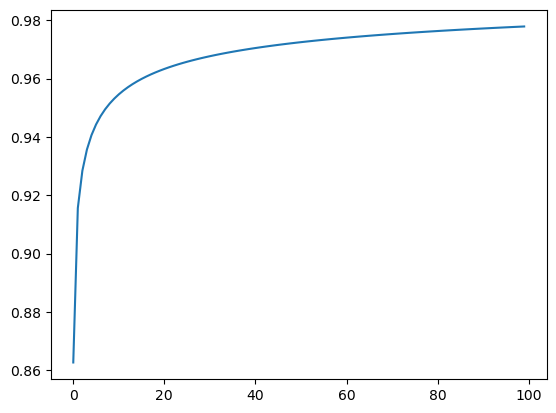

In [2]:
x = np.arange(100)
a = 17; b = 0.675
Sx = np.exp((x/a)**b - ((x+1)/a)**b)
plt.plot(Sx)

Now convert it to mortality (just 1 minus survival) and find a reasonably well fitting function. Looks like a simple exponential won't do the job.

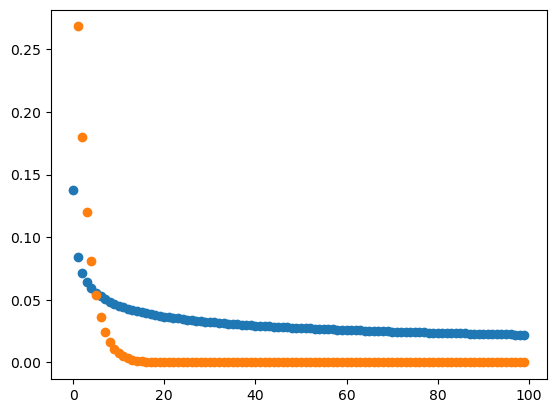

In [3]:
plt.scatter(x,1-Sx)
lam = 0.4
plt.scatter(x[1:],lam*np.exp(-lam*x[1:]))

Weibull function doesn't fit well either. The problem is that these normalized distributions asymptote to zero, whereas we want a mortality to bottom out at a minimum but nonzero value. 

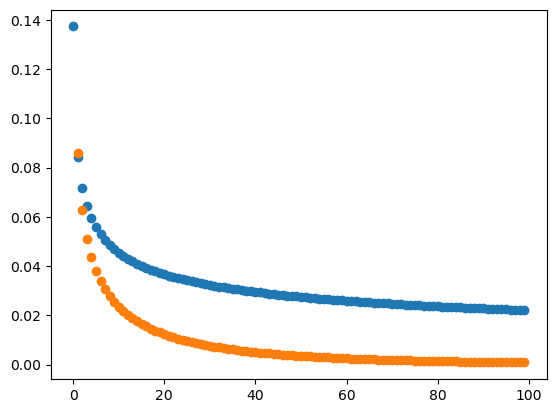

In [4]:
plt.scatter(x,1-Sx)
a = 17; b = 0.675
norm = (b/a) * (x[1:]/a)**(b-1)
plt.scatter(x[1:],norm*np.exp(-(x[1:]/a)**b))

But, I **think** it's fine if the mortality function isn't normalized. Intuitively it doesn't make sense for mortality to decrease to zero. I think as long as mortality is always less than 1, as this is the rate per individual, we're fine. When it get's translated to a binomial probability, we take e^(-mortality), so it will never be greater than 1.

/var/folders/jd/fczwycqx1lxch_x4svbjh6680000gn/T/ipykernel_15631/1431969129.py:8: RuntimeWarning: divide by zero encountered in power
  return (b/a) * (x/b)**(b-1) * np.exp(-(x/a)**b) + c


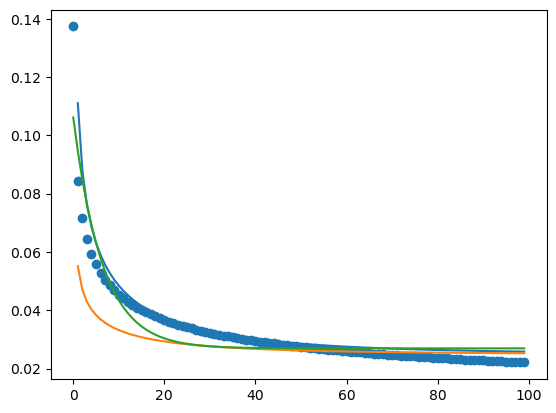

In [11]:
plt.scatter(x,1-Sx)

a = 17; b = 0.675; c = 0.025
norm = (b/a) * (x[1:]/a)**(b-1)
plt.plot(x[1:],norm*np.exp(-(x[1:]/a)**b) + c)

p0 = [17, 0.675, 0.025]
popt, pcov = curve_fit(adjusted_weibull, x, 1-Sx, p0=p0)
plt.plot(x, adjusted_weibull(x, *popt))

popt, pcov = curve_fit(scaled_exp, x, 1-Sx, p0=p0)
plt.plot(x, scaled_exp(x, *popt))

#### The new data
To converted recorded counts $\Bigl[\frac{\#}{\text{plot}}\Bigr]$ to density in $\Bigl[\frac{\#}{\text{ha}}\Bigr]$, do $\Bigl[\frac{\#}{\text{plot}}\Bigr] * \Bigl(\frac{100\text{m}^2}{\text{plot}}\Bigr)^{-1} * \Bigl(\frac{1\text{ha}}{10000\text{m}^2}\Bigr)^{-1}=\Bigl[\frac{\#}{\text{plot}}\Bigr]*100$

In [3]:
df = pd.read_excel('AACypress_Full.xlsx')
df_sub = df[df['SPECIESCODE'] == 'Cupfor']
tstar_vec = np.array([1,2,5])
unitid_vec = np.unique(np.array(df['UNITID']))
plot_vec = np.unique(np.array(df['PLOT']))
dummy = np.array([np.nan for tstar in tstar_vec])
# density_vec = np.array(np.broadcast_to(dummy, (len(plot_vec), len(tstar_vec))))
# Create separate density vectors for seedlings and saplings
shape = (len(unitid_vec), len(plot_vec), len(tstar_vec))
seedlings = np.array(np.broadcast_to(dummy, shape))
saplings = np.array(np.broadcast_to(dummy, shape))

fire_year = 2003

for unitid_i, unitid in enumerate(unitid_vec):
    for plot in plot_vec:
        for tstar_i, tstar in enumerate(tstar_vec):
            year = fire_year + tstar
            counts = df_sub[(df_sub['YEAR'] == year) & (df_sub['PLOT'] == plot) & (df_sub['UNITID'] == unitid) & (df_sub['GROWTHFORM'] == 'Seedling')]['TOTALIN'].sum()
            seedlings[unitid_i][plot-1][tstar_i] = counts * 1e2
            counts = df_sub[(df_sub['YEAR'] == year) & (df_sub['PLOT'] == plot) & (df_sub['UNITID'] == unitid) & (df_sub['GROWTHFORM'] == 'Resprout')]['TOTALIN'].sum()
            saplings[unitid_i][plot-1][tstar_i] = counts * 1e2

total_density = seedlings + saplings
# total_density = seedlings

interactive(children=(FloatSlider(value=0.0, description='unitid_i', max=4.0, step=1.0), Output()), _dom_class…

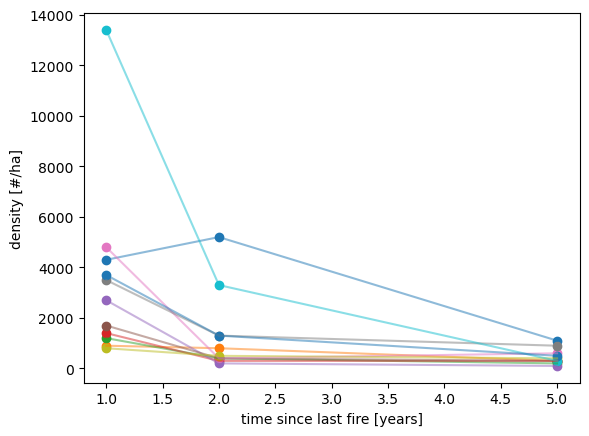

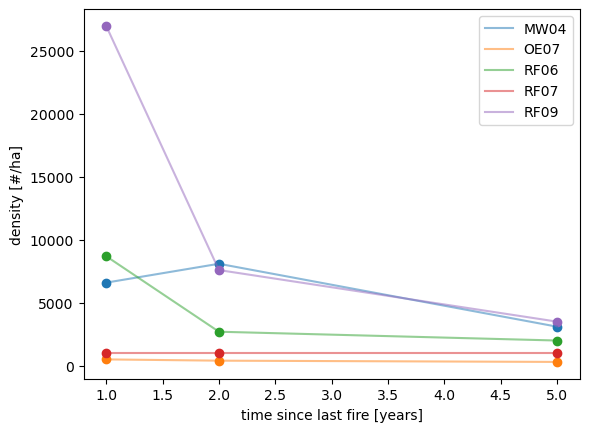

In [4]:
estimate_final = False
if estimate_final:
    tstar_vec = np.append(tstar_vec, 14)
    mortality_yr2_avg = np.mean([-1*(density_vec[plot-1][1] - density_vec[plot-1][0]) / density_vec[plot-1][0] for plot in plot_vec])
    mortality_yr5_avg = np.mean([-1*(density_vec[plot-1][2] - density_vec[plot-1][1]) / density_vec[plot-1][1] for plot in plot_vec])
    init_density = np.array([10000,18500,29000,182000]) #From table 1
    final_density = np.array([606,6788,11745,22562])
    estimated_yr5_density = init_density * mortality_yr2_avg * (4*mortality_yr5_avg)
    scale = np.mean(final_density / estimated_yr5_density)
    estimated = np.zeros((len(plot_vec),1))
    for i, val in enumerate(density_vec[:,2]): 
        estimated[i][0] = scale*val
    density_vec = np.hstack((density_vec, estimated))

def densities_int(unitid_i):
    density_vec = total_density[int(unitid_i)]
    x = tstar_vec
    for plot in plot_vec:
        y = density_vec[plot-1]
        plt.scatter(x,y)
        plt.plot(x,y,alpha=0.5,label=plot)
    plt.legend()
    plt.ylabel('density [#/ha]')
    plt.xlabel('time since last fire [years]')
interact(densities_int, unitid_i = widgets.FloatSlider(value=0, min=0, max=4, step=1))
plt.show()

for unitid_i in range(len(unitid_vec)):
    x = tstar_vec
    for plot in plot_vec:
        y = total_density[unitid_i][plot-1]
        if y[0] < 800:
            continue
        plt.scatter(x,y)
        plt.plot(x,y,alpha=0.5,label=plot)
        # y = seedlings[unitid_i][plot-1]
        # plt.scatter(x,y, color='blue')
        # plt.plot(x,y,alpha=0.5,label=plot, color='blue')
        # y = saplings[unitid_i][plot-1]
        # plt.scatter(x,y, color='pink')
        # plt.plot(x,y,alpha=0.5,label=plot, color='pink')
    # plt.legend()
    plt.ylabel('density [#/ha]')
    plt.xlabel('time since last fire [years]')
plt.show()
    

density_vec = np.array(np.broadcast_to(dummy, (len(unitid_vec), len(tstar_vec))))
for i in range(len(unitid_vec)):
    for t_i in range(len(tstar_vec)):
        density_vec[i][t_i] = total_density[i,:,t_i].sum()
x = tstar_vec
for unitid_i, unitid in enumerate(unitid_vec):
    y = density_vec[unitid_i]
    plt.scatter(x,y)
    plt.plot(x,y,alpha=0.5,label=unitid)
plt.legend()
plt.ylabel('density [#/ha]')
plt.xlabel('time since last fire [years]')
plt.show()

In [5]:
total_density = total_density.reshape((50,3))
min_density_filter = np.nonzero(total_density[:,0] < 800)
total_density = np.delete(total_density, min_density_filter, axis=0)
# Also filter seedlings and saplings
seedlings = seedlings.reshape((50,3))
seedlings = np.delete(seedlings, min_density_filter, axis=0)
saplings = saplings.reshape((50,3))
saplings = np.delete(saplings, min_density_filter, axis=0)

In [6]:
total_density

array([[ 4300.,  5200.,  1100.],
       [  900.,   800.,   300.],
       [ 1200.,   400.,   200.],
       [ 1400.,   300.,   300.],
       [ 2700.,   200.,   100.],
       [ 1700.,   400.,   300.],
       [ 4800.,   400.,   600.],
       [ 3500.,  1300.,   900.],
       [  800.,   500.,   400.],
       [13400.,  3300.,   300.],
       [ 3700.,  1300.,   500.]])

In [7]:
# Save processed observations to file
np.save('observations.npy', total_density)

In [6]:
mortality_vec = np.empty((total_density.shape[0], len(tstar_vec)-1))
mortality_vec[:] = np.nan
for m_i, plot_density in enumerate(total_density):
    for tstar_i, tstar in enumerate(tstar_vec[:-1]):
        # Calculate density change relative to initial
        delta_t = tstar_vec[tstar_i+1] - tstar
        delta_density = plot_density[tstar_i+1] - plot_density[tstar_i]
        prop_density_change = delta_density / plot_density[tstar_i]
        mortality = (-1 * prop_density_change) / delta_t
        mortality_vec[m_i][tstar_i] = mortality

(-0.25, 1.0)

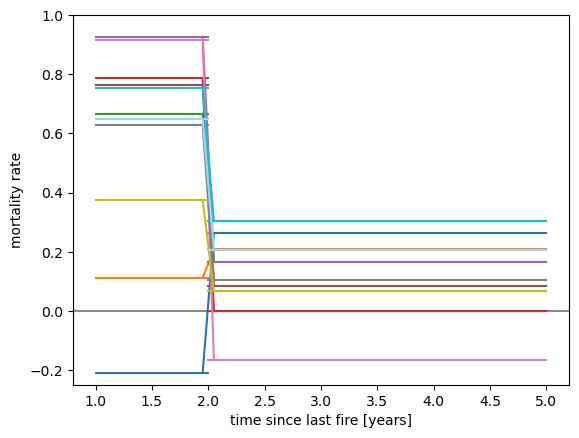

In [7]:
color = plt.cm.tab20(np.linspace(0, 1, mortality_vec.shape[0]))
for plot_i, plot_mortality in enumerate(mortality_vec):
    plt.plot([1,2], plot_mortality[0].repeat(2), color=color[plot_i])
    plt.plot([2,5], plot_mortality[1].repeat(2), color=color[plot_i])
    plt.plot([1.95,2.05], plot_mortality, color=color[plot_i])

plt.ylabel('mortality rate')
plt.xlabel('time since last fire [years]')
plt.axhline(0,ls='-',alpha=0.45,zorder=-1, color='black')
# plt.xlim(1,14)
plt.ylim(-0.25,1)

#### Test out different fit functions

In [22]:
def adjusted_weibull_intplt(a,b,c):
    # return (b/a) * (x/b)**(b-1) * np.exp(-(x/a)**b) + c
    for plot in plot_vec:
        x = tstar_vec[1:]
        plt.scatter(x,mortality_vec[plot-1])
        plt.plot(x,mortality_vec[plot-1], alpha=0.5)
    mean_mortality_vec = np.mean(mortality_vec, axis=0)
    plt.scatter(x,mean_mortality_vec, color='black')
    plt.plot(x,mean_mortality_vec, ls='--', color='black')
    x = np.arange(0,25)
    plt.plot(x, adjusted_weibull(x,a,b,c), color='red')
    plt.scatter(x, adjusted_weibull(x,a,b,c), color='red', s=10)
    
    plt.ylabel('mortality rate')
    plt.xlabel('time since last fire [years]')
    plt.axhline(0,ls='-',alpha=0.45,zorder=-1, color='black')
interact(adjusted_weibull_intplt, a = widgets.FloatSlider(value=2.57779941, min=0.01, max=10, step=0.01),
         b = widgets.FloatSlider(value=2.22861074, min=0.01, max=10, step=0.01),
         c = widgets.FloatSlider(value=0.09423809, min=0.01, max=0.1, step=0.01))

interactive(children=(FloatSlider(value=2.57779941, description='a', max=10.0, min=0.01, step=0.01), FloatSlid…

<function __main__.adjusted_weibull_intplt(a, b, c)>

In [8]:
def scaled_exp_intplt(a,b,c):
    for plot_i, plot_mortality in enumerate(mortality_vec):
        plt.plot([1,2], plot_mortality[0].repeat(2), color=color[plot_i])
        plt.plot([2,5], plot_mortality[1].repeat(2), color=color[plot_i])
        plt.plot([1.95,2.05], plot_mortality, color=color[plot_i])
    # mean_mortality_vec = np.mean(mortality_vec, axis=0)
    x = np.arange(0,10)
    # plt.scatter(x,mean_mortality_vec, color='black')
    # plt.plot(x,mean_mortality_vec, ls='--', color='black')
    plt.plot(x, scaled_exp(x,a,b,c), color='red')
    plt.scatter(x, scaled_exp(x,a,b,c), color='red', s=10)
    
    plt.ylabel('mortality rate')
    plt.xlabel('time since last fire [years]')
    plt.axhline(0,ls='-',alpha=0.45,zorder=-1, color='black')
interact(scaled_exp_intplt, a = widgets.FloatSlider(value=1.69, min=0.01, max=10, step=0.01),
         b = widgets.FloatSlider(value=0.77, min=0.001, max=1.5, step=0.001),
         c = widgets.FloatSlider(value=0.04, min=0.01, max=0.1, step=0.01))

interactive(children=(FloatSlider(value=1.69, description='a', max=10.0, min=0.01, step=0.01), FloatSlider(val…

<function __main__.scaled_exp_intplt(a, b, c)>

In [25]:
def norm_int(g, h, t):
    N = 1000
    # logn_draws = np.random.lognormal(1.0,g*np.exp(-h*t),N)
    norm_draws = np.random.normal(1.0,g*np.exp(-h*t),N)
    plt.hist(norm_draws, bins=50);
interact(norm_int,
        g = widgets.FloatSlider(value=0.75, min=0.0, max=2, step=0.05),
        h = widgets.FloatSlider(value=0.01, min=0.001, max=0.5, step=0.001),
        t = widgets.FloatSlider(value=0, min=0, max=50, step=1))

interactive(children=(FloatSlider(value=0.75, description='g', max=2.0, step=0.05), FloatSlider(value=0.01, de…

<function __main__.norm_int(g, h, t)>

In [26]:
def lognorm_int(g, h, t):
    N = 1000
    # logn_draws = np.random.lognormal(0.0,g-h*t,N)
    logn_draws = np.random.lognormal(0.0,g*np.exp(-h*t),N)
    plt.hist(logn_draws, bins=50);
interact(lognorm_int,
        g = widgets.FloatSlider(value=0.75, min=0.0, max=2, step=0.05),
        h = widgets.FloatSlider(value=0.01, min=0.001, max=0.5, step=0.001),
        t = widgets.FloatSlider(value=0, min=0, max=50, step=1))

interactive(children=(FloatSlider(value=0.75, description='g', max=2.0, step=0.05), FloatSlider(value=0.01, de…

<function __main__.lognorm_int(g, h, t)>

#### Suss out non-fire year reproduction rates
Think we want small initial baseline rates with high initial environmental stochasticity, both of which decay quickly.

In [14]:
r_1 = seedlings[:,1] / total_density[:,0]; r_1

array([0.04651163, 0.88888889, 0.        , 0.        , 0.        ,
       0.05882353, 0.        , 0.        , 0.125     , 0.        ,
       0.        ])

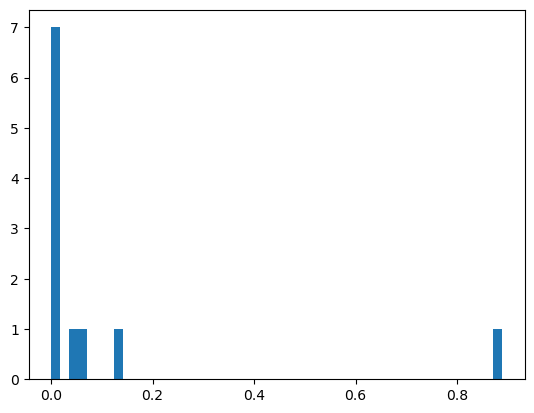

In [19]:
plt.hist(r_1, bins=50);

In [27]:
def nonfire_repro(beta_r, sigma_r, tau_r, tstar):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
    x = np.arange(0,15)
    y = np.exp(-beta_r * x)
    ax1.scatter(x,y)
    ax1.plot(x,y)
    ax1.set_ylim(-0.05,1.05)
    ax1.set_title(r'$r_{t^*}$')
    # ax1.show()
    
    # Now plot histogram of env stoch distribution
    N = 1000
    # logn_draws = np.random.lognormal(0.0,g-h*t,N)
    logn_draws = np.random.lognormal(0.0,sigma_r*np.exp(-tau_r*tstar),N)
    ax2.hist(logn_draws, bins=50);
    ax2.set_title(r'$\epsilon_r$')
    
interact(nonfire_repro, beta_r = widgets.FloatSlider(value=1, min=0.01, max=2, step=0.01),
        sigma_r = widgets.FloatSlider(value=1.4, min=0.0, max=2, step=0.05),
        tau_r = widgets.FloatSlider(value=0.2, min=0.001, max=1, step=0.0001),
        tstar = widgets.FloatSlider(value=1, min=0, max=50, step=1))

interactive(children=(FloatSlider(value=1.0, description='beta_r', max=2.0, min=0.01, step=0.01), FloatSlider(…

<function __main__.nonfire_repro(beta_r, sigma_r, tau_r, tstar)>

In [28]:
def lognorm(mu, sigma):
    N = 1000
    # logn_draws = np.random.lognormal(0.0,g-h*t,N)
    logn_draws = np.random.lognormal(mu,sigma,N)
    plt.hist(logn_draws, bins=50);
    plt.axvline(logn_draws.mean(), color='red')
    
interact(lognorm, mu = widgets.FloatSlider(value=0, min=-1, max=1, step=0.01),
               sigma = widgets.FloatSlider(value=0.01, min=0.01, max=2.5, step=0.01))


interactive(children=(FloatSlider(value=0.0, description='mu', max=1.0, min=-1.0, step=0.01), FloatSlider(valu…

<function __main__.lognorm(mu, sigma)>

### Density dependence

#### Playing with functional form

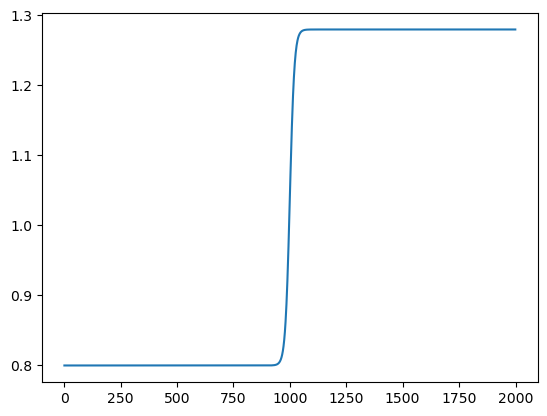

In [42]:
'''Sketching out what the final mortality rates look like when m_min=0.1 and 
   m_max=m_min*d(t_star)=m_min*1.6'''
N = np.arange(1,2000,1); N
m_min_t = 0.8
m_max_t = m_min_t * 0.6
r = 0.1
K_t = 1000
m = m_min_t + m_max_t / (1+np.exp(-r*(N-K_t)))
plt.plot(N,m)

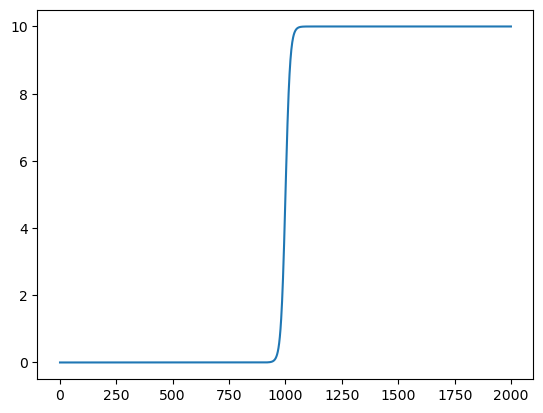

In [39]:
N = np.arange(1,2000,1); N
m_min_t = 0.8
m_max_t = 10
r = 0.1
K_t = 1000
m = m_max_t / (1+np.exp(-r*(N-K_t)))
plt.plot(N,m)

array([0.61854478, 0.18939396, 0.08853605])

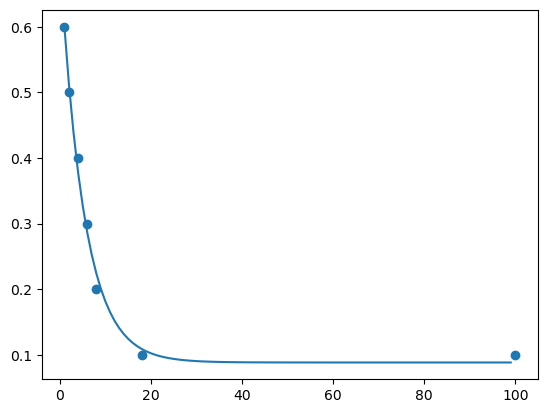

In [48]:
# Assumptions from Regan 2012
d_t = np.array([1.6,1.5,1.4,1.3,1.2,1.1,1.1])
d_t = d_t - 1
# d_t = 1 - d_t
t = np.array([1,2,4,6,8,18,100])
plt.scatter(t,d_t)

# x = np.concatenate((np.array([0.0000000001,0.0000000001,0.0001,0.1,0.5]), np.arange(100)))
x = np.arange(1,100)

# lam = 0.3
# plt.plot(x,lam*np.exp(-lam*x) + 1.1) 

# d = 0.3
# e = 2
# f = 
# plt.plot(x,lam*np.exp(-lam*x) + 1.1) 

# a = 17; b = 0.675; c = 1.1
# norm = (b/a) * (x/a)**(b-1)
# plt.scatter(x,norm*np.exp(-(x/a)**b) + c)

# popt, pcov = curve_fit(adjusted_weibull, t, d_t)
# plt.plot(t, adjusted_weibull(t, *popt))
# popt

# popt, pcov = curve_fit(weibull, t, d_t)
# plt.plot(t, weibull(t, *popt)); popt

# popt, pcov = curve_fit(exp, t, d_t)
# plt.plot(t, exp(t, *popt)); popt

def scaled_exp(x,d,e,f):
    return d*np.exp(-e*x) + f
popt, pcov = curve_fit(scaled_exp, t, d_t)
plt.plot(x, scaled_exp(x, *popt)); popt

#### Looking at the data
Run mortality cells first

Data on both seedling K looks reasonably close to Mark-Nich. Seems like K will be at a much lower value for "adults" than previous model, though, given the data at age 14.

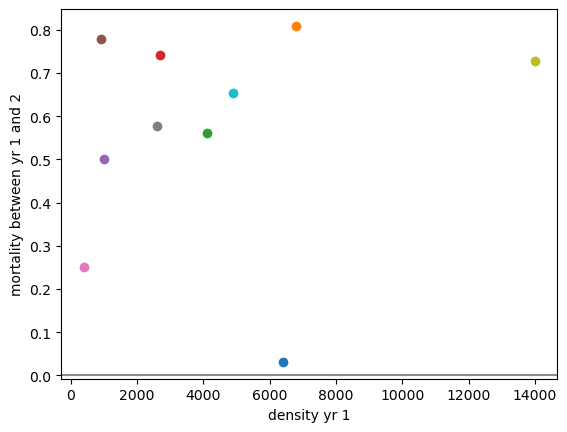

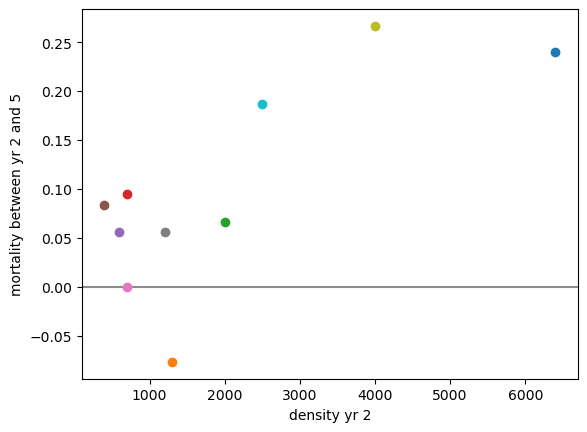

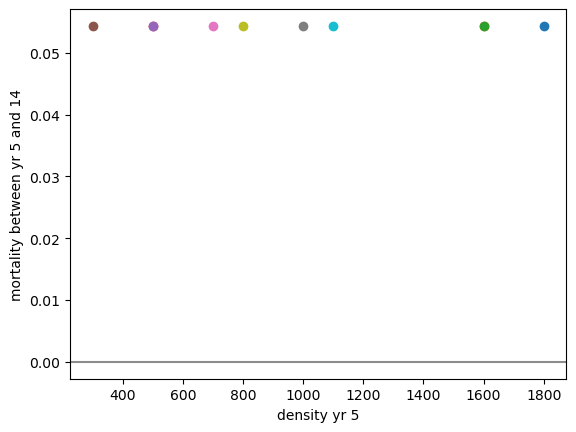

In [9]:
for tstar_i, tstar in enumerate(tstar_vec[:-1]):
    for plot in plot_vec:
        # Try correcting for second year birth pulse
        if tstar == 1:
            year = fire_year + tstar
            counts_yr2 = df_sub[(df_sub['YEAR'] == year+1) & (df_sub['GROWTHFORM'] == 'Resprout') & (df_sub['PLOT'] == plot)]['TOTALIN']
            density_yr2 = counts_yr2.sum()*1e2
            corrected_mortality = -1*(density_yr2 - density_vec[plot-1][tstar_i]) / density_vec[plot-1][tstar_i]
            plt.scatter(density_vec[plot-1][tstar_i], corrected_mortality)
        else:
        # if True:
            plt.scatter(density_vec[plot-1][tstar_i], mortality_vec[plot-1][tstar_i])
    plt.axhline(0,ls='-',alpha=0.45,zorder=-1, color='black')
    plt.ylabel('mortality between yr {} and {}'.format(tstar, tstar_vec[tstar_i+1]))
    plt.xlabel('density yr {}'.format(tstar))
    plt.show()

(0.0, 50.0)

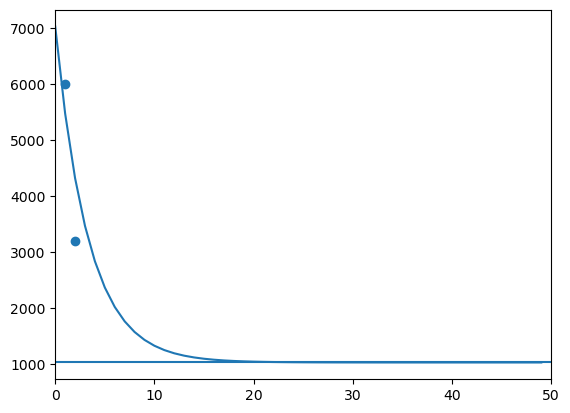

In [22]:
plt.scatter([1,2],[6000, 3200])
plt.axhline(1024)
# plt.axhline(70)
x = np.arange(0,50)
plt.plot(x, 6000*np.exp(-0.3*x) + 1024)
plt.xlim(0,50)

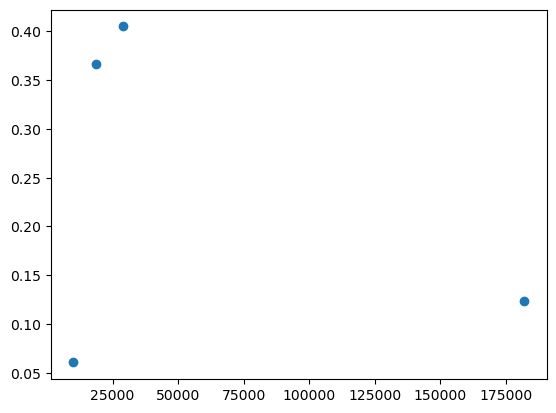

In [77]:
plt.scatter(init_density, final_density / init_density)

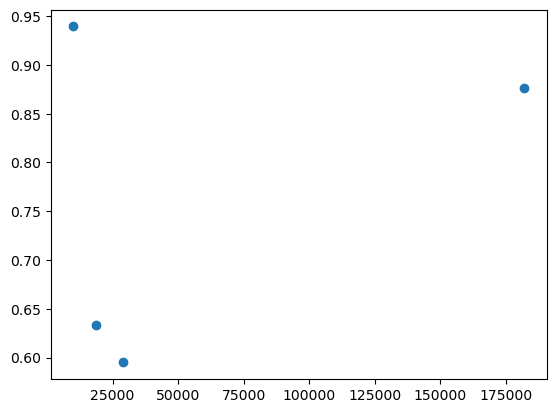

In [79]:
plt.scatter(init_density, (init_density - final_density) / init_density)